In [ ]:
!pip install efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=15fd6ba23b60978a358dccbffe9ec1e3ad2a9ff1a1fb800b595b3986954454e0
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import re
import os
from tqdm import tqdm_notebook as tqdm

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
effnet=EfficientNet.from_pretrained('efficientnet-b4')
effnet.cuda()

class centernet(nn.Module):
  def __init__(self):
    super(centernet,self).__init__()
    self.encoder=effnet.extract_features
    self.conv1 = nn.Conv2d(1792,1024,3,1,padding= (1,1))
    self.conv2 = nn.Conv2d(1024,512,3,1,padding= (1,1))
    self.conv3 = nn.Conv2d(512,256,3,1,padding= (1,1))
    self.conv4 = nn.Conv2d(256,128,3,1,padding= (1,1))
    self.conv5 = nn.Conv2d(128,64,3,1,padding= (1,1))
    self.conv6 = nn.Conv2d(64,1,3,1,padding= (1,1))
    self.conv7 = nn.Conv2d(64,2,3,1,padding=(1,1))
    self.upsample = nn.Upsample(scale_factor= 2)

  def forward(self,x):
    x=self.encoder(x) # size is 18x15x1792
    x=self.upsample(x)
    x=F.leaky_relu(self.conv1(x))
    x=F.leaky_relu(self.conv2(x))
    x=F.leaky_relu(self.conv3(x)) #36x30x256
    x = self.upsample(x)
    x=F.leaky_relu(self.conv4(x)) #72x60x128
    x = self.upsample(x)
    x=F.leaky_relu(self.conv5(x))
    outc=self.conv6(x)
    outr=self.conv7(x)
    return outc,outr

model=centernet()
model.cuda()
print(model)  

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth



Loaded pretrained weights for efficientnet-b4
centernet(
  (conv1): Conv2d(1792, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode=nearest)
)


In [ ]:
# Check if it runs correctly
img=cv2.imread('../content/drive/MyDrive/x.jpg')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img=np.array(img,dtype='float32')
img=cv2.resize(img,(512,512))
img=img.reshape(1,3,512,512)
img=torch.from_numpy(img)
img = img.to(device)
model=model.to(device)
print(model(img)[0].shape)
print(model(img)[1].shape)

torch.Size([1, 1, 128, 128])
torch.Size([1, 2, 128, 128])


In [ ]:
MODEL_PATH = ""
input_size = 512
IN_SCALE = 1024//input_size 
MODEL_SCALE = 4
batch_size = 2
TRAIN = True 

In [ ]:
DIR_INPUT = '../content/drive/MyDrive/global_wheat_detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape

(147793, 5)

In [ ]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

In [ ]:
# Split train-test
from sklearn.model_selection import train_test_split
# Split by unique image ids.
image_ids = train_df['image_id'].unique()
train_id, test_id = train_test_split(image_ids, test_size=0.2, random_state=777)

In [ ]:
from torchvision import transforms

class Normalize(object):
    def __init__(self):
        self.mean=[0.485, 0.456, 0.406]
        self.std=[0.229, 0.224, 0.225]
        self.norm = transforms.Normalize(self.mean, self.std)
    def __call__(self, image):
        image = image.astype(np.float32)/255
        axis = (0,1)
        image -= self.mean
        image /= self.std
        return image
    
# pool duplicates
def pool(data):
    stride = 3
    for y in np.arange(1,data.shape[1]-1, stride):
        for x in np.arange(1, data.shape[0]-1, stride):
            a_2d = data[x-1:x+2, y-1:y+2]
            max = np.asarray(np.unravel_index(np.argmax(a_2d), a_2d.shape))            
            for c1 in range(3):
                for c2 in range(3):
                    #print(c1,c2)
                    if not (c1== max[0] and c2 == max[1]):
                        data[x+c1-1, y+c2-1] = -1
    return data

class WheatDataset(torch.utils.data.Dataset):
    def __init__(self, img_id, labels, transform=None):
        self.img_id = img_id
        self.labels = labels
        if transform:
            self.transform = transform
        self.normalize = Normalize()
        
    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(DIR_INPUT,"train", self.img_id[idx]+".jpg"))
        img = cv2.resize(img, (input_size, input_size))
        img = self.normalize(img)
        img = img.transpose([2,0,1])
        target = self.labels[self.labels['image_id']==self.img_id[idx]]
        hm,regr= make_hm_regr(target)
        return img, hm, regr

# Submission
class WheatDatasetTest(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.img_id = os.listdir(self.image_dir)
        if transform:
            self.transform = transform
        self.normalize = Normalize()
        
    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.image_dir, self.img_id[idx]))
        img = cv2.resize(img, (input_size, input_size))
        img = self.normalize(img)
        img = img.transpose([2,0,1])
        return img, self.img_id[idx]

In [ ]:
traindataset = WheatDataset(train_id, train_df)
valdataset = WheatDataset(test_id, train_df)
testdataset = WheatDatasetTest('../content/drive/MyDrive/global_wheat_detection/test')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


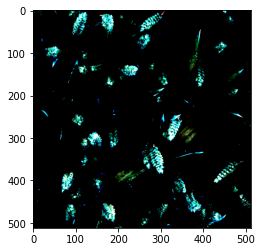

In [ ]:
# Test dataset
img,hm,regr=traindataset[0]
x=traindataset[0][0]
x=x.transpose([1,2,0])
plt.imshow(x)

In [ ]:
train_loader = torch.utils.data.DataLoader(traindataset,batch_size=batch_size,shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(valdataset,batch_size=batch_size,shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(testdataset,batch_size=batch_size,shuffle=False, num_workers=0)

In [ ]:
# Make heatmaps using the utility functions from the centernet repo
def draw_msra_gaussian(heatmap, center, sigma=2):
  tmp_size = sigma * 6
  mu_x = int(center[0] + 0.5)
  mu_y = int(center[1] + 0.5)
  w, h = heatmap.shape[0], heatmap.shape[1]
  ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
  br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
  if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
    return heatmap
  size = 2 * tmp_size + 1
  x = np.arange(0, size, 1, np.float32)
  y = x[:, np.newaxis]
  x0 = y0 = size // 2
  g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
  g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
  g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
  img_x = max(0, ul[0]), min(br[0], h)
  img_y = max(0, ul[1]), min(br[1], w)
  heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
    g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
  return heatmap

In [ ]:
# Wrapped heatmap function
def make_hm_regr(target):
    # make output heatmap for single class
    hm = np.zeros([input_size//MODEL_SCALE, input_size//MODEL_SCALE])
    # make regr heatmap 
    regr = np.zeros([2, input_size//MODEL_SCALE, input_size//MODEL_SCALE])
    
    if len(target) == 0:
        return hm, regr
    
    try:
        center = np.array([target["x"]+target["w"]//2, target["y"]+target["h"]//2, 
                       target["w"], target["h"]
                      ]).T
    except:
        center = np.array([int(target["x"]+target["w"]//2), int(target["y"]+target["h"]//2), 
                       int(target["w"]), int(target["h"])
                      ]).T.reshape(1,4)
    
    # make a center point
    # try gaussian points.
    for c in center:
        hm = draw_msra_gaussian(hm, [int(c[0])//MODEL_SCALE//IN_SCALE, int(c[1])//MODEL_SCALE//IN_SCALE], 
                                sigma=np.clip(c[2]*c[3]//2000, 2, 4))    

    # convert targets to its center.
    regrs = center[:, 2:]/input_size/IN_SCALE

    # plot regr values to mask
    for r, c in zip(regrs, center):
        for i in range(-2, 3):
            for j in range(-2, 3):
                try:
                    regr[:, int(c[0])//MODEL_SCALE//IN_SCALE+i, 
                         int(c[1])//MODEL_SCALE//IN_SCALE+j] = r
                except:
                    pass
    regr[0] = regr[0].T; regr[1] = regr[1].T;
    return hm, regr


In [ ]:
def pred2box(hm, regr, thresh=0.99):
    # make binding box from heatmaps
    # thresh: threshold for logits.
        
    # get center
    pred = hm > thresh
    pred_center = np.where(hm>thresh)
    # get regressions
    pred_r = regr[:,pred].T

    # wrap as boxes
    # [xmin, ymin, width, height]
    # size as original image.
    boxes = []
    scores = hm[pred]
    for i, b in enumerate(pred_r):
        arr = np.array([pred_center[1][i]*MODEL_SCALE-b[0]*input_size//2, pred_center[0][i]*MODEL_SCALE-b[1]*input_size//2, 
                      int(b[0]*input_size), int(b[1]*input_size)])
        arr = np.clip(arr, 0, input_size)
        # filter 
        #if arr[0]<0 or arr[1]<0 or arr[0]>input_size or arr[1]>input_size:
            #pass
        boxes.append(arr)
    return np.asarray(boxes), scores

In [ ]:
# functions for plotting results
def showbox(img, hm, regr, thresh=0.9):
    boxes, _ = pred2box(hm, regr, thresh=thresh)
    print("preds:",boxes.shape)
    sample = img

    for box in boxes:
        # upper-left, lower-right
        cv2.rectangle(sample,
                      (int(box[0]), int(box[1]+box[3])),
                      (int(box[0]+box[2]), int(box[1])),
                      (220, 0, 0), 3)
    return sample
def showgtbox(img, hm, regr, thresh=0.9):
    boxes, _ = pred2box(hm, regr, thresh=thresh)
    print("GT boxes:", boxes.shape)
    sample = img

    for box in boxes:
        cv2.rectangle(sample,
                      (int(box[0]), int(box[1]+box[3])),
                      (int(box[0]+box[2]), int(box[1])),
                      (0, 220, 0), 3)
    return sample

GT boxes: (70, 4)


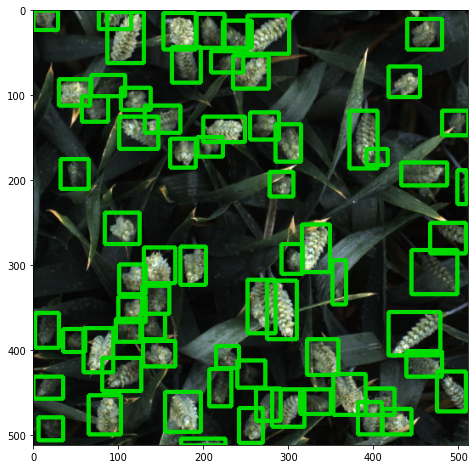

In [ ]:
# Let's first make sure that we can convert targets to heatmaps and bring it back to boxes.
# show image
#img_id = train_df["image_id"][]
img_id = train_id[0]
img = cv2.imread(os.path.join(DIR_INPUT,"train", img_id+".jpg"))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (input_size, input_size))
sample = img

# get labels
target = train_df[train_df['image_id']==img_id]

# convert target to heatmaps
hm, regr = make_hm_regr(target)

# get boxes
boxes, _ = pred2box(hm, regr)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sample = showgtbox(sample, hm, regr, 0.99)
plt.imshow(sample)
plt.show()

In [ ]:
def neg_loss(pred, gt):
  ''' Modified focal loss. Exactly the same as CornerNet.
      Runs faster and costs a little bit more memory
    Arguments:
      pred (batch x c x h x w)
      gt_regr (batch x c x h x w)
  '''
  pred = pred.unsqueeze(1).float()
  gt = gt.unsqueeze(1).float()

  pos_inds = gt.eq(1).float()
  neg_inds = gt.lt(1).float()
  neg_weights = torch.pow(1 - gt, 4)

  loss = 0

  pos_loss = torch.log(pred + 1e-12) * torch.pow(1 - pred, 3) * pos_inds
  neg_loss = torch.log(1 - pred + 1e-12) * torch.pow(pred, 3) * neg_weights * neg_inds

  num_pos  = pos_inds.float().sum()
  pos_loss = pos_loss.sum()
  neg_loss = neg_loss.sum()

  if num_pos == 0:
    loss = loss - neg_loss
  else:
    loss = loss - (pos_loss + neg_loss) / num_pos
  return loss

def centerloss(prediction, mask, regr,weight=0.4, size_average=True):
    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0])
    mask_loss = neg_loss(pred_mask, mask)
    
    # Regression L1 loss
    pred_regr = prediction[:, 1:]
    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1)
    regr_loss = regr_loss.mean(0)
  
    # Sum
    loss = mask_loss +regr_loss
    if not size_average:
        loss *= prediction.shape[0]
    return loss ,mask_loss , regr_loss

In [ ]:
t = tqdm(train_loader)
i=0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for idx,(image,hm_gt,regr_gt) in enumerate(t):
  image=image.to(device)
  hm,regr=model(image)
  print(hm.shape)
  print(regr.shape)
  i+=1
  if i==5:
    break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


torch.Size([2, 1, 128, 128])
torch.Size([2, 2, 128, 128])
torch.Size([2, 1, 128, 128])
torch.Size([2, 2, 128, 128])
torch.Size([2, 1, 128, 128])
torch.Size([2, 2, 128, 128])
torch.Size([2, 1, 128, 128])
torch.Size([2, 2, 128, 128])
torch.Size([2, 1, 128, 128])
torch.Size([2, 2, 128, 128])


In [ ]:
def train(epoch):
    optimizer=optim.Adam(model.parameters(),lr=1e-4)
    model.train()
    print('epochs {}/{} '.format(epoch+1,epochs))
    running_loss = 0.0
    running_mask = 0.0
    running_regr = 0.0
    t = tqdm(train_loader)
    rd = np.random.rand()
    
    for idx, (img, hm, regr) in enumerate(t):       
        # send to gpu
        img = img.to(device)
        hm_gt = hm.to(device)
        regr_gt = regr.to(device)
        # set opt
        optimizer.zero_grad()
        
        # run model
        hm,regr = model(img)
        preds = torch.cat((hm,regr),1)    
        loss, mask_loss, regr_loss = centerloss(preds, hm_gt, regr_gt)
        # misc
        running_loss += loss
        running_mask += mask_loss
        running_regr += regr_loss
        
        loss.backward()
        optimizer.step()
        
        t.set_description(f't (l={running_loss/(idx+1):.3f})(m={running_mask/(idx+1):.4f})(r={running_regr/(idx+1):.4f})')
        
    #scheduler.step()
    print('train loss : {:.4f}'.format(running_loss/len(train_loader)))
    print('maskloss : {:.4f}'.format(running_mask/(len(train_loader))))
    print('regrloss : {:.4f}'.format(running_regr/(len(train_loader))))
    
    # save logs
    log_epoch = {'epoch': epoch+1, 'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                    'loss': running_loss/len(train_loader), "mask": running_mask/(len(train_loader)), 
                 "regr": running_regr/(len(train_loader))}
    logs.append(log_epoch)

In [ ]:
#epochs=100
epochs = 5
logs = []
logs_eval = []

if TRAIN:
    for epoch in range(epochs):
        train(epoch)
else:
    model.load_state_dict(torch.load(MODEL_PATH))

epochs 1/5 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



train loss : 1.3778
maskloss : 1.3028
regrloss : 0.0749
epochs 2/5 



train loss : 1.1395
maskloss : 1.0691
regrloss : 0.0704
epochs 3/5 



train loss : 1.1097
maskloss : 1.0426
regrloss : 0.0671
epochs 4/5 



train loss : 1.0674
maskloss : 1.0018
regrloss : 0.0656
epochs 5/5 



train loss : 1.0530
maskloss : 0.9884
regrloss : 0.0647


In [ ]:
checkpoint={'state_dict':model.state_dict()}
torch.save(checkpoint, "model_weights_new2.pth.tar")

In [ ]:
def load_checkpoint(checkpoint):
  model.load_state_dict(checkpoint['state_dict'])

load_checkpoint(torch.load("model_weights_new2.pth.tar"))

preds: (0,)
GT boxes: (51, 4)


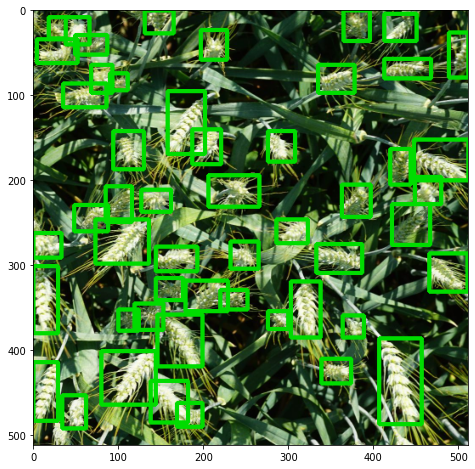

preds: (1, 4)
GT boxes: (29, 4)


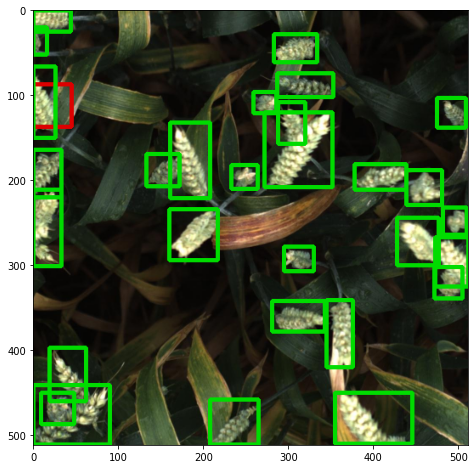

preds: (0,)
GT boxes: (80, 4)


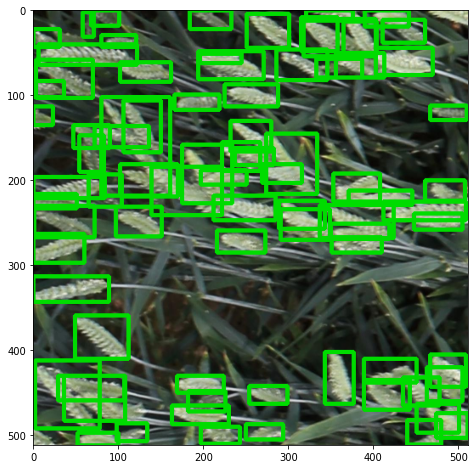

preds: (0,)
GT boxes: (80, 4)


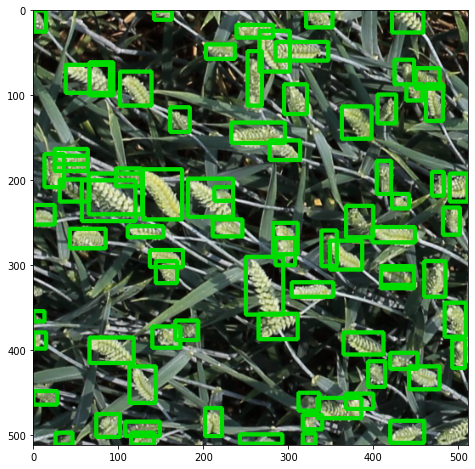

preds: (0,)
GT boxes: (10, 4)


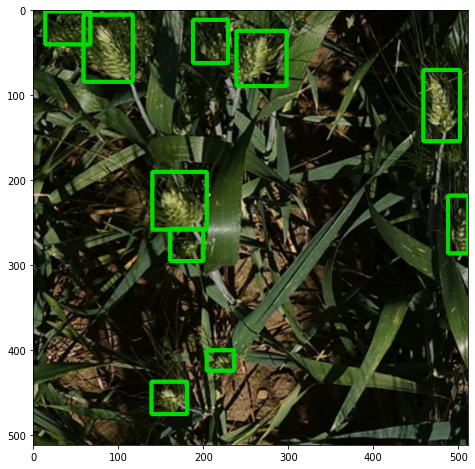

preds: (0,)
GT boxes: (38, 4)


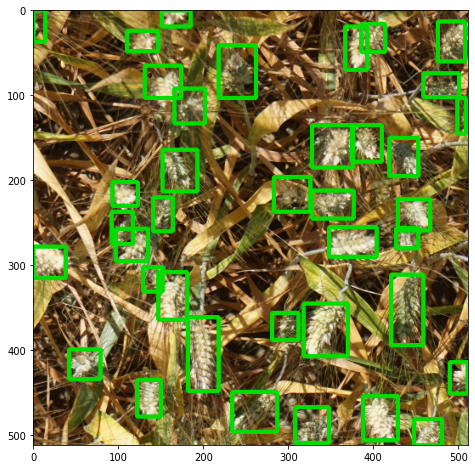

preds: (0,)
GT boxes: (16, 4)


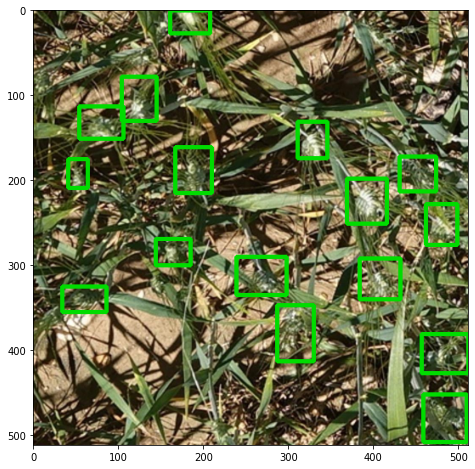

preds: (0,)
GT boxes: (30, 4)


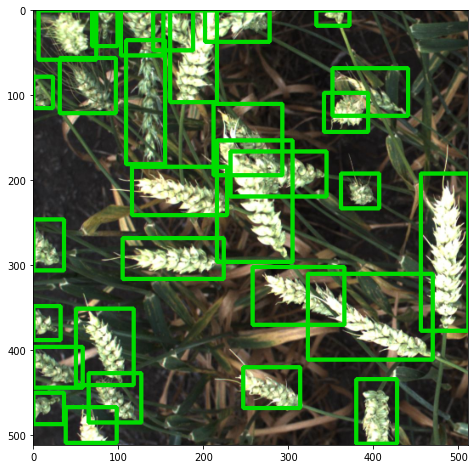

preds: (0,)
GT boxes: (61, 4)


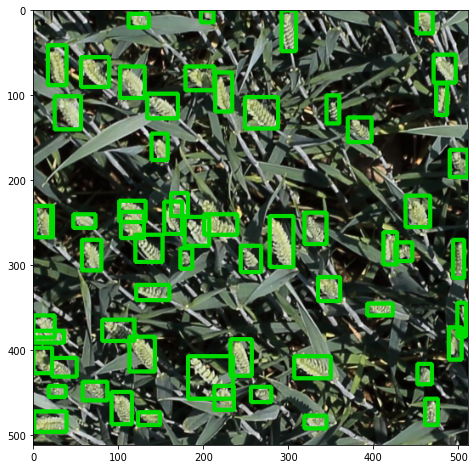

preds: (0,)
GT boxes: (63, 4)


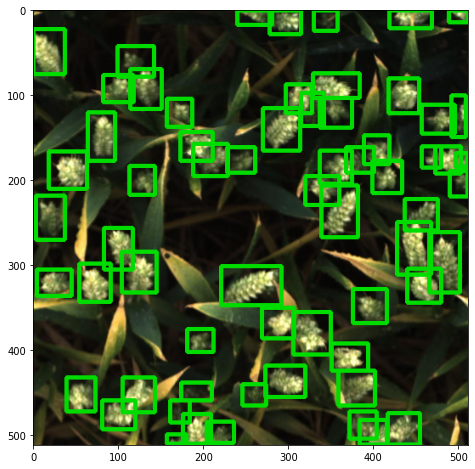

In [ ]:
for id in range(10):
    img, hm_gt, regr_gt = valdataset[id]
    img = torch.from_numpy(img)
    with torch.no_grad():
        hm,regr = model(img.to(device).float().unsqueeze(0))
    
    hm = hm.cpu().numpy().squeeze(0).squeeze(0)
    regr = regr.cpu().numpy().squeeze(0)

    # show image
    img_id = test_id[id]
    img = cv2.imread(os.path.join(DIR_INPUT,"train", img_id+".jpg"))
    img = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (input_size, input_size))

     # get boxes
    hm = torch.sigmoid(torch.from_numpy(hm)).numpy()
    hm = pool(hm)
    sample = showbox(img, hm, regr, 0.6)

    
    # show gt
    sample = showgtbox(sample, hm_gt, regr_gt, 0.99)
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    plt.imshow(sample)
    plt.show()